In [44]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import *
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
to_arr = lambda x: x.detach().numpy()
import pickle
def pickle_save(obj, path):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)
def pickle_load(path):
    with open(path, 'rb') as f:
        return pickle.load(f, encoding='latin1')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


to get the CIFAR data run
```
wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
tar -xzvf cifar-10-python.tar.gz
rm cifar-10-python.tar.gz 
```

In [4]:
%%script False  # uncomment this to use all data
from cifar_utils import get_CIFAR10_data
data = get_CIFAR10_data(num_training=100, num_validation=200)
for k, v in data.items():
  print('%s: ' % k, v.shape)
X_labeled = data['X_train']
y_labeled = pd.get_dummies(data['y_train']).values
X_unlabeled = data['X_val']
pickle_save((X_labeled, y_labeled, X_unlabeled), 'cifar_subset.pkl')

In [2]:
(X_labeled, y_labeled, X_unlabeled) = pickle_load('cifar_subset.pkl')

In [27]:
from mixmatch import ArrayDataset, MixupLoader, MixMatchLoss
from torch.utils.data import DataLoader

### Torch Version

In [28]:
from torch import nn
class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)



In [29]:
from torch.optim import Adam

In [66]:
distro = torch.distributions.beta.Beta(.4, .5)
distro

tensor([0.4578, 0.4299, 0.4866, 0.0171, 0.6654, 0.9683, 0.6270, 0.3169, 0.0034,
        0.6346])

In [69]:
#ds = ArrayDataset(X_labeled[:12], y_labeled[:12], X_unlabeled[:12])
ds = ArrayDataset(X_labeled, y_labeled, X_unlabeled)
BS = 4
loader = MixupLoader(ds, batch_size=BS)
model = nn.Sequential(
    nn.Conv2d(3, 2, 3, stride=1, padding=1),
    Flatten(),
    nn.Linear(2 * 32 * 32, 10),
)
loader.model = model
optimizer = Adam(model.parameters(),lr=.0001)
loss_fn = MixMatchLoss()
losses = []
for i in tqdm_notebook(range(100)):
    for xb,yb in loader:
        optimizer.zero_grad()
        preds = F.softmax(model.forward(xb), dim=1)
        loss = loss_fn(preds, yb, BS//2)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()

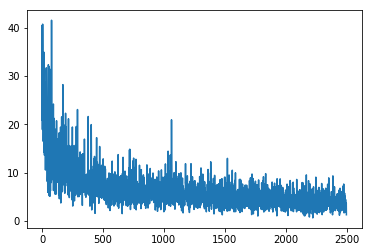

In [71]:
plt.plot(losses)

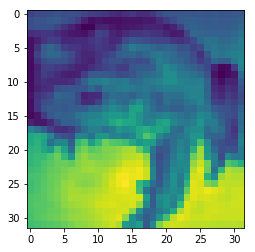

In [72]:

plt.imshow(xb[-1].detach().numpy()[0])

Text(0.5, 1.0, 'Sharpened+ Guessed Labels')

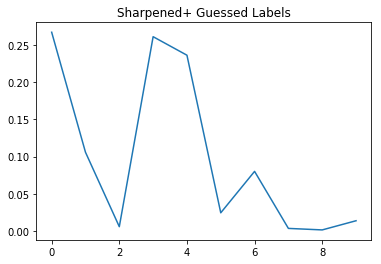

In [73]:
plt.plot(yb[-1].detach().numpy())
plt.title('Sharpened+ Guessed Labels')